In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels
import pickle
import matplotlib.pyplot as plt
import time
import warnings
import itertools
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 100

def show_ts(ts, forecast=None, forecast2 = None, title="Forecast Plot"):
    ax = ts.plot(label = "Observed", figsize=(10,3))
    if not (forecast is None):
        forecast.plot(ax=ax, label='Forecast')
        plt.legend()
    if not (forecast2 is None):
        forecast2.plot(ax=ax, label='Forecast')
        plt.legend()durations_df
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Messages/Second')
    plt.title(title)
    plt.show()

def optimizeHoltWinters(ts, mult):
    combinations = ["add","mul"]
    best_model = None
    bestr_c = None
    best_aic = np.inf
    for c in combinations:
        model = ExponentialSmoothing(train.t, seasonal_periods=mult*24, seasonal=c, 
                                     initialization_method="estimated").fit()
        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            best_model = model
            best_c = c
    return best_model, best_c
    
durations_df = pd.read_csv("results/durations.csv")



avazu 1h
Train shape: (210, 1)
Test shape: (53, 1)
                          t   LASTOBSERVED   LASTDAY  SimpleExpSmoothing  \
date                                                                       
2014-10-29 18:00:00  107210  110567.000000  119895.0       110578.879693   
2014-10-29 19:00:00  106346  108888.500000  115932.0       108902.862046   
2014-10-29 20:00:00  105281  108041.000000  112005.0       108052.042771   
2014-10-29 21:00:00  102586  107351.000000  111515.0       107360.618834   
2014-10-29 22:00:00  101903  106398.000000  106190.0       106408.395414   
2014-10-29 23:00:00  102916  105648.833333  104841.0       105658.076596   
2014-10-30 00:00:00  101519  105258.428571  102991.0       105265.630284   
2014-10-30 01:00:00  102023  104791.000000  105521.0       104798.171469   
2014-10-30 02:00:00  102929  104483.444444  108342.0       104489.542950   
2014-10-30 03:00:00  105853  104328.000000  119352.0       104333.034413   
2014-10-30 04:00:00  134527  104466

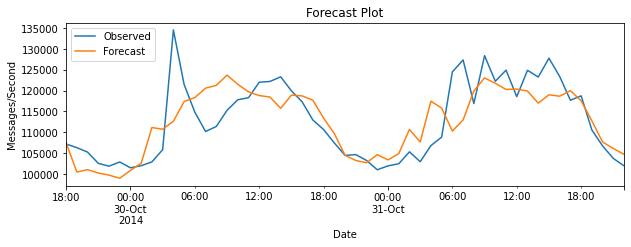



avazu 15min
Train shape: (841, 1)
Test shape: (211, 1)
100 / 211
20.06.2022 16:15:50


KeyboardInterrupt: 

In [2]:
# Triple Exponential Smoothing aka Holt Winter's Exponential Smoothing
data_names = ["avazu","IoT","wiki_de","wiki_en","horton","retailrocket","taxi", "alibaba", "google"]

sampling_rates = ["1h","15min","5min"]
multipliers = [1,4,12]
forecast_horizons = [12,4,1]

train_test_split = 0.8

for data_name in data_names:
    for i,sampling_rate in enumerate(sampling_rates):
        print()
        print()
        print(data_name, sampling_rate)
        multiplier = multipliers[i]
        fh = forecast_horizons[i]
        df = pd.read_csv("../data/"+data_name+"_"+sampling_rate+".csv", index_col=0, parse_dates=True)
durations_df
        df["t"] = df.messages
        df = df.drop(["messages"], axis=1)
        df = df.dropna()
        df = df.astype(np.int)

        train = df.iloc[:int(len(df)*train_test_split)]
        test = df.iloc[int(len(df)*train_test_split):]
        
        print("Train shape:", train.shape)
        print("Test shape:", test.shape)
        start_time = time.time()
        model, hyper_params = optimizeHoltWinters(train.t, multiplier)
        end_time = time.time()
        training_duration = end_time-start_time
        
        durations_df.loc[(durations_df.dataset == data_name) & (durations_df.sampling_rate == sampling_rate)\
                         , "ExpSmoothing"] = training_duration
        
        try:
            results_df = pd.read_csv("results/"+ data_name + "_" + sampling_rate + "_results.csv", index_col=0, parse_dates=True)
        except:
            results_df = test.t.to_frame()
            
        results_df["ExpSmoothing"] = 0
        results_df["ExpSmoothing"].iloc[:fh] = model.forecast(fh).values
        
        i = 1
        start_time = time.time()
        while i < len(results_df):
            ts = train.t.append(test.t.iloc[:i])
            model = ExponentialSmoothing(ts, seasonal_periods=24*multiplier, 
                             seasonal=hyper_params, initialization_method="estimated").fit()
            try:
                results_df["ExpSmoothing"].iloc[i:i+fh] += model.forecast(fh).values
            except ValueError:
                results_df["ExpSmoothing"].iloc[i:] += model.forecast(len(results_df)-i).values
            i += 1
            if i % 100 ==0:
                print(i,"/",len(test))
                print((datetime.now() + timedelta(hours=2)).strftime("%d.%m.%Y %H:%M:%S"))
        end_time = time.time()
        
        tuning_duration = (end_time - start_time) / len(results_df)
        durations_df.loc[(durations_df.dataset == data_name) & (durations_df.sampling_rate == sampling_rate)\
                         , "ExpSmoothing_tune"] = tuning_duration
        
        great_divider = list(range(1,len(results_df)+1))
        great_divider = list(map(lambda x: min(x,fh), great_divider))
        results_df["ExpSmoothing"] /= great_divider
        
        print(results_df)

        show_ts(results_df.t, results_df.ExpSmoothing)
        results_df.to_csv("results/"+data_name+"_"+sampling_rate+"_results.csv")

        durations_df.to_csv("results/durations.csv", index=False)